In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
import numpy as np

# Construct Ratings Matrix

In [3]:
# load in data -- taken from https://cseweb.ucsd.edu/~jmcauley/datasets/goodreads.html
df = pd.read_json('goodreads_reviews_spoiler.json',lines=True)
df_genre = pd.read_json('goodreads_book_genres_initial.json',lines=True)
df_genre.head()

,book_id,genres
0,5333265,"{'history, historical fiction, biography': 1}"
1,1333909,"{'fiction': 219, 'history, historical fiction,..."
2,7327624,"{'fantasy, paranormal': 31, 'fiction': 8, 'mys..."
3,6066819,"{'fiction': 555, 'romance': 23, 'mystery, thri..."
4,287140,{'non-fiction': 3}


In [4]:
# merge datasets so that we can get the fuzzy genre tags for all of the books
merged_df = pd.merge(df, df_genre, on='book_id', how='left')
merged_df = merged_df[['rating', 'book_id', 'user_id', 'genres']]
merged_df.head()

,rating,book_id,user_id,genres
0,5,18245960,8842281e1d1347389f2ab93d60773d4d,"{'fiction': 393, 'fantasy, paranormal': 341, '..."
1,3,16981,8842281e1d1347389f2ab93d60773d4d,"{'fiction': 3501, 'history, historical fiction..."
2,3,28684704,8842281e1d1347389f2ab93d60773d4d,"{'fiction': 3969, 'mystery, thriller, crime': ..."
3,0,27161156,8842281e1d1347389f2ab93d60773d4d,"{'non-fiction': 4371, 'history, historical fic..."
4,4,25884323,8842281e1d1347389f2ab93d60773d4d,"{'fiction': 1108, 'fantasy, paranormal': 132}"


In [5]:
# create indicators for each of the genres 
def create_genre_indicators(genre_dict):
    indicators = {}
    for genre in genre_dict.keys():
        genres = genre.split(':')
        genre_name = genres[0].strip().strip("'\"")
        indicators[genre_name] = 1
    return indicators
    
# Apply the function to the 'genres' column and expand the dictionary into separate columns
genre_indicators = merged_df['genres'].apply(create_genre_indicators).apply(pd.Series).fillna(0)
genre_indicators.head()

,fiction,"fantasy, paranormal","mystery, thriller, crime","history, historical fiction, biography",non-fiction,romance,"comics, graphic",young-adult,children,poetry
0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
4,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
# sort the genres by popularity
genre_indicators = genre_indicators[genre_indicators.sum().sort_values(ascending=False).index] # sort by popularity
df_final = pd.concat([merged_df, genre_indicators], axis=1)
df_final.head()

# drop irrelevant columns 
df = df_final.drop(columns=['genres', 'book_id', 'rating', "fiction"])
user_genre_counts = df.groupby('user_id').sum().reset_index()

# get favorite genre of users to make genre groups
user_cols = ['user_id']
user_genre_counts['favorite_genre'] = user_genre_counts.drop(columns=user_cols).idxmax(axis=1)
user_genre_counts['favorite_genre'].head()

0                     romance
1                     romance
2    mystery, thriller, crime
3                     romance
4                     romance
Name: favorite_genre, dtype: object

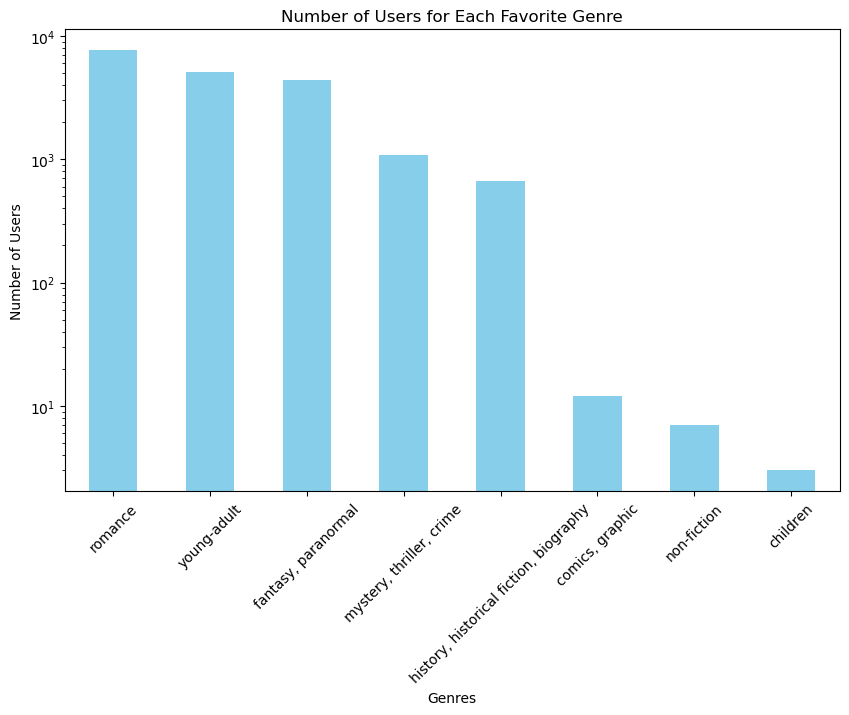

In [18]:
# here is a visualization of the SIZE of different genre groups!

favorite_genre_counts = user_genre_counts['favorite_genre'].value_counts()
# Plotting the barplot
plt.figure(figsize=(10, 6))
favorite_genre_counts.plot(kind='bar', color='skyblue', logy=True)
plt.title('Number of Users for Each Favorite Genre')
plt.xlabel('Genres')
plt.ylabel('Number of Users')
plt.xticks(rotation=45)
plt.show()

In [20]:
# we will also sort USERS by their favorite genre
sorted_genres = favorite_genre_counts.index 

# Sort users by their favorite genre based on the popularity of the genre
sorted_user_genre_counts = user_genre_counts.set_index('favorite_genre').loc[sorted_genres].reset_index()

# Drop the 'user_id' and 'favorite_genre' columns to get the sorted ratings matrix
sorted_ratings_matrix = sorted_user_genre_counts.drop(columns=['user_id', 'favorite_genre'])

# save csv for future use
sorted_ratings_matrix.to_csv("sorted_ratings_matrix.csv")

# Visualizations

In [22]:
# load in matrix from previous section
user_genre_counts = pd.read_csv("sorted_ratings_matrix.csv")
user_genre_counts = user_genre_counts.drop(columns=["Unnamed: 0"])
user_genre_counts.head()

,romance,young-adult,"fantasy, paranormal","mystery, thriller, crime","history, historical fiction, biography",children,"comics, graphic",non-fiction,poetry
0,171.0,134.0,118.0,103.0,14.0,5.0,1.0,1.0,1.0
1,76.0,25.0,9.0,20.0,2.0,1.0,0.0,1.0,0.0
2,17.0,2.0,1.0,6.0,4.0,1.0,0.0,0.0,0.0
3,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
4,105.0,60.0,29.0,19.0,5.0,1.0,0.0,0.0,0.0


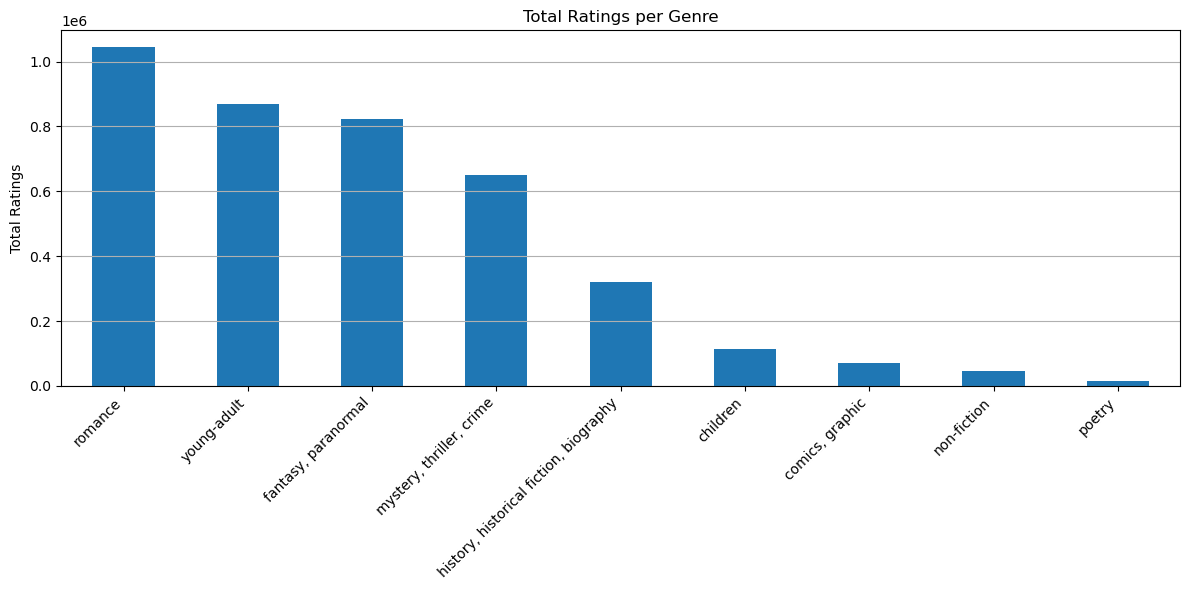

,romance,young-adult,"fantasy, paranormal","mystery, thriller, crime","history, historical fiction, biography",children,"comics, graphic",non-fiction,poetry,favorite_genre
0,171.0,134.0,118.0,103.0,14.0,5.0,1.0,1.0,1.0,romance
1,76.0,25.0,9.0,20.0,2.0,1.0,0.0,1.0,0.0,romance
2,17.0,2.0,1.0,6.0,4.0,1.0,0.0,0.0,0.0,romance
3,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,romance
4,105.0,60.0,29.0,19.0,5.0,1.0,0.0,0.0,0.0,romance


In [24]:
# Visualize "Item" Popularity

genre_totals = user_genre_counts.sum().sort_values(ascending=False)

# Plotting
plt.figure(figsize=(12, 6))
genre_totals.plot(kind='bar')
plt.title('Total Ratings per Genre')
plt.ylabel('Total Ratings')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(axis='y')

# Display the plot
plt.show()

# Add favorite genre!
favorite_genres = user_genre_counts.idxmax(axis=1)
user_genre_counts['favorite_genre'] = favorite_genres
user_genre_counts.head()

In [26]:
# rank the popular genres
temp = user_genre_counts[genre_totals.index]
genre_popularity_rank = genre_totals.rank(ascending=False, method='first')

# sort users by popularity of their favorite genre
user_genre_counts["genre_popularity_rank"] = user_genre_counts["favorite_genre"].map(genre_popularity_rank)
user_genre_counts = user_genre_counts.sort_values(by="genre_popularity_rank").reset_index(drop=True)

# create a numeric ratings matrix
sorted_ratings_matrix = user_genre_counts.drop(columns=["genre_popularity_rank", "favorite_genre"])
R = sorted_ratings_matrix
m,n = R.shape[0], R.shape[1]
genres = R.columns.to_list()

In [28]:
# save the list of popular genres 
genres_ordered_by_popularity = genre_popularity_rank.sort_values().index.tolist()
genres_ordered_by_popularity

['romance',
 'young-adult',
 'fantasy, paranormal',
 'mystery, thriller, crime',
 'history, historical fiction, biography',
 'children',
 'comics, graphic',
 'non-fiction',
 'poetry']

In [30]:
# Here is the R!!
sorted_ratings_matrix.head()

,romance,young-adult,"fantasy, paranormal","mystery, thriller, crime","history, historical fiction, biography",children,"comics, graphic",non-fiction,poetry
0,171.0,134.0,118.0,103.0,14.0,5.0,1.0,1.0,1.0
1,5.0,2.0,4.0,5.0,0.0,0.0,0.0,0.0,0.0
2,35.0,35.0,34.0,11.0,6.0,0.0,1.0,0.0,0.0
3,51.0,31.0,20.0,10.0,3.0,1.0,4.0,0.0,0.0
4,52.0,42.0,22.0,12.0,4.0,0.0,1.0,0.0,0.0


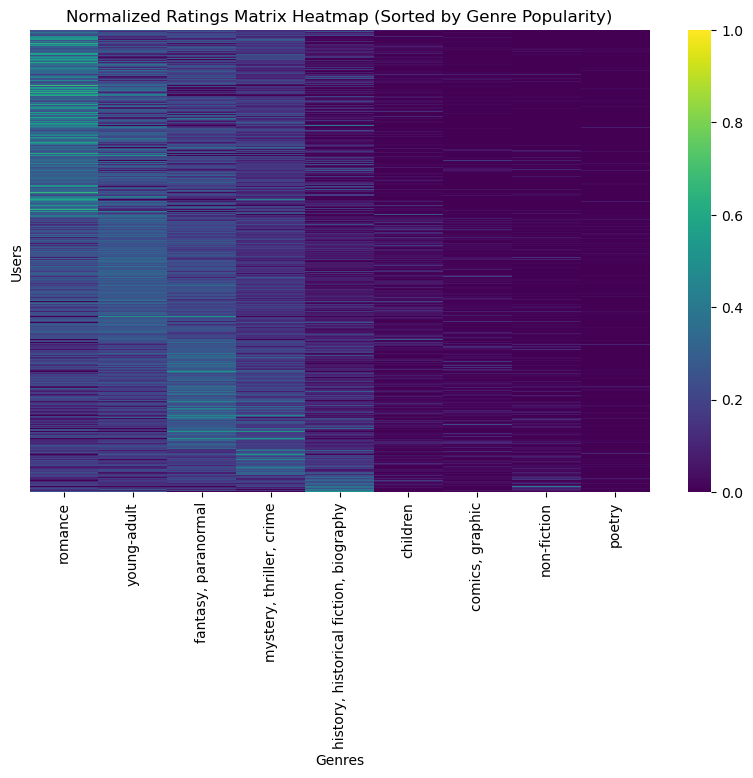

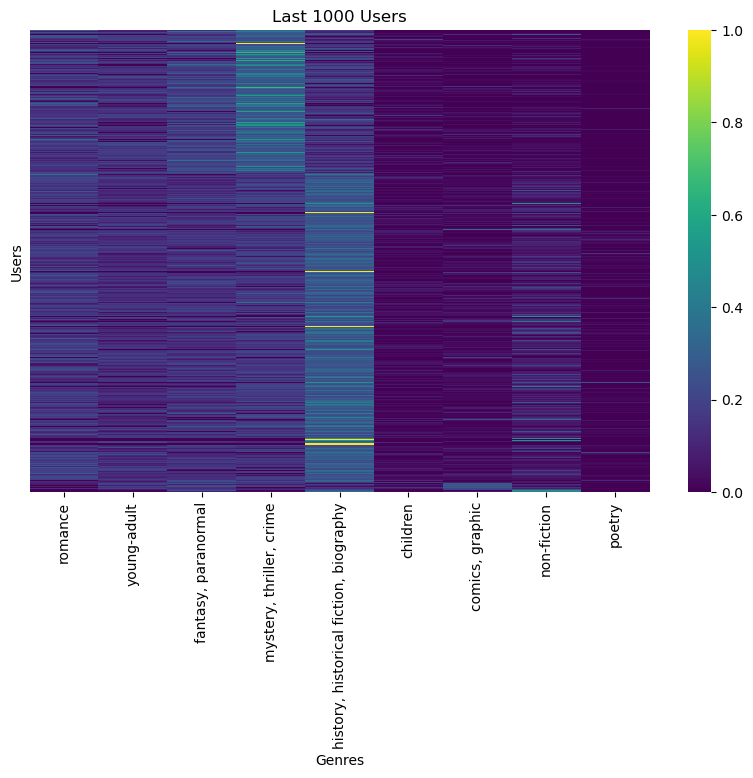

In [41]:
# Plotting the heatmap
normalized_ratings_matrix = sorted_ratings_matrix.div(sorted_ratings_matrix.sum(axis=1), axis=0)

plt.figure(figsize=(10, 6))
sns.heatmap(normalized_ratings_matrix, cmap='viridis', cbar=True)
plt.title('Normalized Ratings Matrix Heatmap (Sorted by Genre Popularity)')
plt.xlabel('Genres')
plt.ylabel('Users')
plt.yticks([], [])
plt.savefig('pics/ratings_matrix.png')
plt.show()


normalized_ratings_matrix = sorted_ratings_matrix.div(sorted_ratings_matrix.sum(axis=1), axis=0).tail(1000)

plt.figure(figsize=(10, 6))
sns.heatmap(normalized_ratings_matrix, cmap='viridis', cbar=True)
plt.title('Last 1000 Users')
plt.xlabel('Genres')
plt.ylabel('Users')
plt.yticks([], [])
plt.savefig('pics/block_ratings_matrix.png')
plt.show()

In [42]:
print(genres)
print(genres_ordered_by_popularity)

['romance', 'young-adult', 'fantasy, paranormal', 'mystery, thriller, crime', 'history, historical fiction, biography', 'children', 'comics, graphic', 'non-fiction', 'poetry']
['romance', 'young-adult', 'fantasy, paranormal', 'mystery, thriller, crime', 'history, historical fiction, biography', 'children', 'comics, graphic', 'non-fiction', 'poetry']


In [43]:
user_genre_counts

,romance,young-adult,"fantasy, paranormal","mystery, thriller, crime","history, historical fiction, biography",children,"comics, graphic",non-fiction,poetry,favorite_genre,genre_popularity_rank
0,171.0,134.0,118.0,103.0,14.0,5.0,1.0,1.0,1.0,romance,1.0
1,5.0,2.0,4.0,5.0,0.0,0.0,0.0,0.0,0.0,romance,1.0
2,35.0,35.0,34.0,11.0,6.0,0.0,1.0,0.0,0.0,romance,1.0
3,51.0,31.0,20.0,10.0,3.0,1.0,4.0,0.0,0.0,romance,1.0
4,52.0,42.0,22.0,12.0,4.0,0.0,1.0,0.0,0.0,romance,1.0
...,...,...,...,...,...,...,...,...,...,...,...
18887,0.0,1.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,non-fiction,8.0
18888,0.0,0.0,1.0,0.0,1.0,0.0,0.0,2.0,0.0,non-fiction,8.0
18889,0.0,0.0,1.0,2.0,2.0,0.0,2.0,3.0,0.0,non-fiction,8.0
18890,1.0,2.0,11.0,5.0,50.0,2.0,9.0,63.0,0.0,non-fiction,8.0


In [44]:
favorite_counts = user_genre_counts['favorite_genre'].value_counts()

# 3. Calculate percent of total users for each genre
percent_users = (favorite_counts / len(R)) * 100

# 4. Total rating for each genre across all users
total_rating = R.sum(axis=0)

# Combine into a summary DataFrame
summary_df = pd.DataFrame({
    'Number of Users (Favorite)': favorite_counts,
    'Percent of Total Users (%)': percent_users.round(2),
    'Total Rating': total_rating
}).fillna(0).astype({'Number of Users (Favorite)': int})

# Reset index for a clean output
# summary_df.reset_index(inplace=True)
summary_df.rename(columns={'index': 'Genre'}, inplace=True)

In [45]:
22/m*100

0.11645140800338769

In [46]:
summary_df

,Number of Users (Favorite),Percent of Total Users (%),Total Rating
children,3,0.02,113772.0
"comics, graphic",12,0.06,71078.0
"fantasy, paranormal",4427,23.43,823453.0
"history, historical fiction, biography",668,3.54,319614.0
"mystery, thriller, crime",1087,5.75,649818.0
non-fiction,7,0.04,46797.0
poetry,0,0.00,14266.0
romance,7627,40.37,1044264.0
young-adult,5061,26.79,869081.0


number of majority users is 18202 which constitute 0.963476603853483% of all users
number of minority users is 690 which constitute 0.03652339614651704% of all users


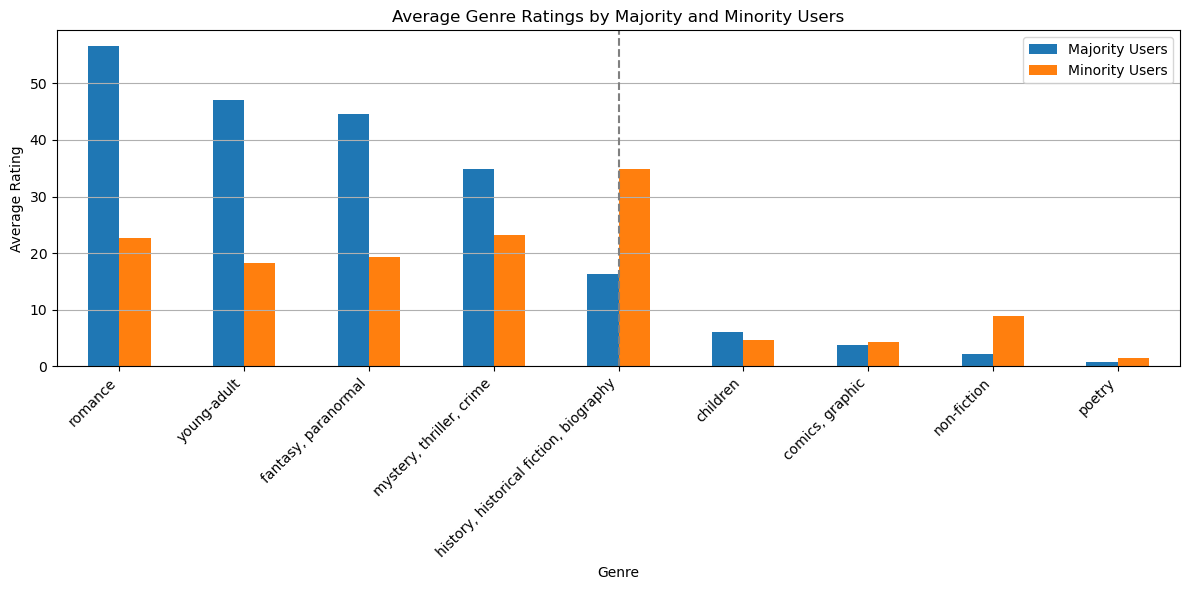

In [47]:
# Step Create Two Groups of Users 
U_MAJ = user_genre_counts[user_genre_counts["genre_popularity_rank"]<=n/2]
U_MIN = user_genre_counts[user_genre_counts["genre_popularity_rank"]>n/2]

# drop irrelevant columns
U_MAJ = U_MAJ.drop(columns = ["genre_popularity_rank", "favorite_genre"])
U_MIN = U_MIN.drop(columns = ["genre_popularity_rank", "favorite_genre"])

print(f"number of majority users is {U_MAJ.shape[0]} which constitute {U_MAJ.shape[0]/user_genre_counts.shape[0]}% of all users")
print(f"number of minority users is {U_MIN.shape[0]} which constitute {U_MIN.shape[0]/user_genre_counts.shape[0]}% of all users")

# save group averages 

avg_MAJ = U_MAJ.mean()
avg_MIN = U_MIN.mean()

avg_df = pd.DataFrame({
    'Majority Users': avg_MAJ,
    'Minority Users': avg_MIN
})

# Step 8: Plotting
avg_df.plot(kind='bar', figsize=(12, 6))
plt.title("Average Genre Ratings by Majority and Minority Users")
plt.ylabel("Average Rating")
plt.xlabel("Genre")
plt.axvline(x=n/2-0.5, color='grey', linestyle='--', linewidth=1.5)

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(axis='y')
plt.savefig('pics/majority_minority.png')
plt.show()
# normalize 
# U_MAJ = U_MAJ.div(U_MAJ.sum(axis=1), axis=0)
# U_MIN = U_MIN.div(U_MIN.sum(axis=1), axis=0)

In [48]:
# Step Create Two Groups of Users 
i_star = 4
def create_plot(i_star):
    U_MAJ = user_genre_counts[user_genre_counts["genre_popularity_rank"]!=i_star]
    U_MIN = user_genre_counts[user_genre_counts["genre_popularity_rank"]==i_star]
    
    # drop irrelevant columns
    U_MAJ = U_MAJ.drop(columns = ["genre_popularity_rank", "favorite_genre"])
    U_MIN = U_MIN.drop(columns = ["genre_popularity_rank", "favorite_genre"])

    U_MAJ = U_MAJ.div(U_MAJ.sum(axis=1), axis=0)
    U_MIN = U_MIN.div(U_MIN.sum(axis=1), axis=0)
    
    print(f"number of majority users is {U_MAJ.shape[0]} which constitute {U_MAJ.shape[0]/user_genre_counts.shape[0]}% of all users")
    print(f"number of minority users is {U_MIN.shape[0]} which constitute {U_MIN.shape[0]/user_genre_counts.shape[0]}% of all users")
    
    # save group averages 
    
    avg_MAJ = U_MAJ.mean()
    avg_MIN = U_MIN.mean()
    
    avg_df = pd.DataFrame({
        'Majority Users': avg_MAJ,
        'Minority Users': avg_MIN
    })
    
    # Step 8: Plotting
    avg_df.plot(kind='bar', figsize=(12, 6))
    plt.title(f"Average Genre Ratings by {genres[i_star-1]} and other users")
    plt.ylabel("Average Rating")
    plt.xlabel("Genre")
    #plt.axvline(x=i_star-0.5, color='grey', linestyle='--', linewidth=1.5)

    
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.grid(axis='y')
    plt.savefig('pics/majority_minority.png')
    plt.show()
    # normalize 
    # U_MAJ = U_MAJ.div(U_MAJ.sum(axis=1), axis=0)
    # U_MIN = U_MIN.div(U_MIN.sum(axis=1), axis=0)

number of majority users is 11265 which constitute 0.5962841414355282% of all users
number of minority users is 7627 which constitute 0.40371585856447173% of all users


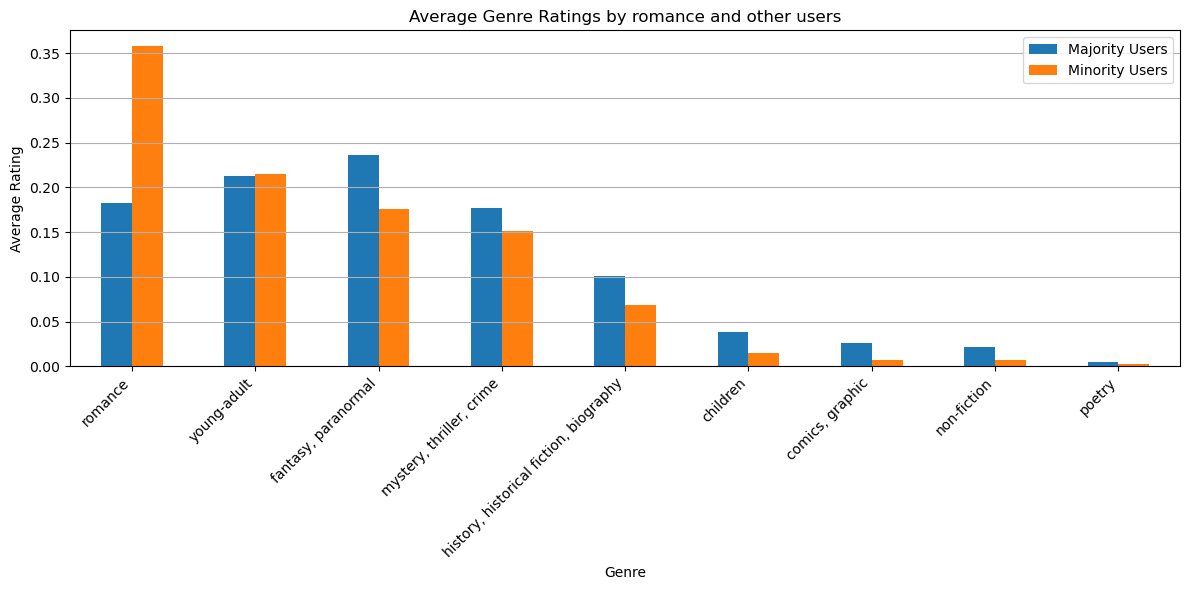

number of majority users is 13831 which constitute 0.732108829134025% of all users
number of minority users is 5061 which constitute 0.267891170865975% of all users


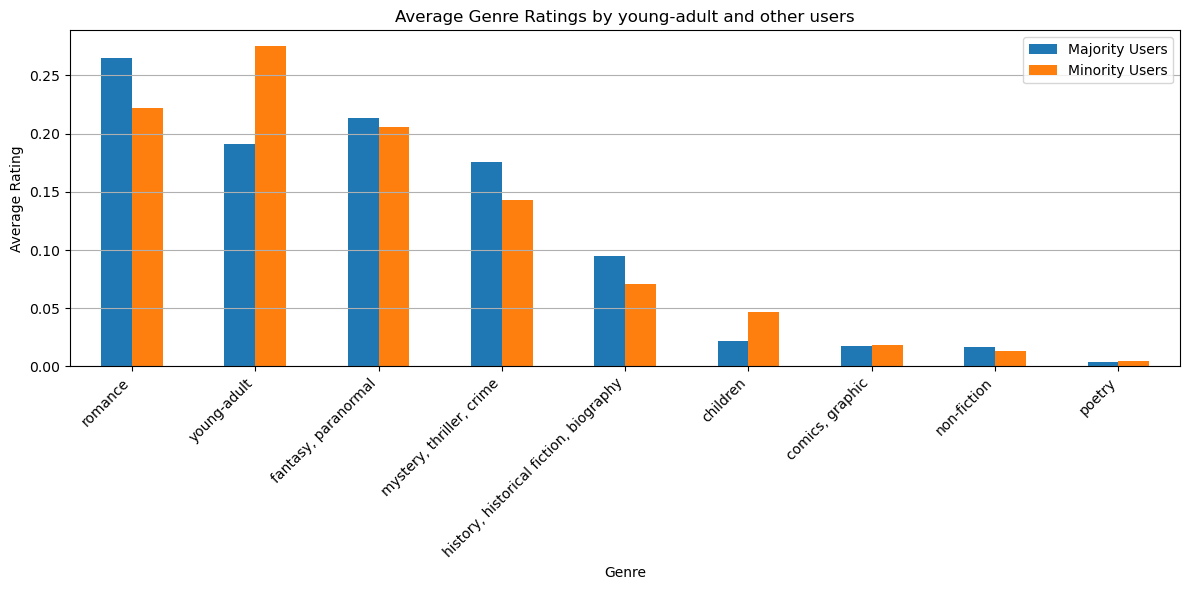

number of majority users is 14465 which constitute 0.7656680076222739% of all users
number of minority users is 4427 which constitute 0.23433199237772603% of all users


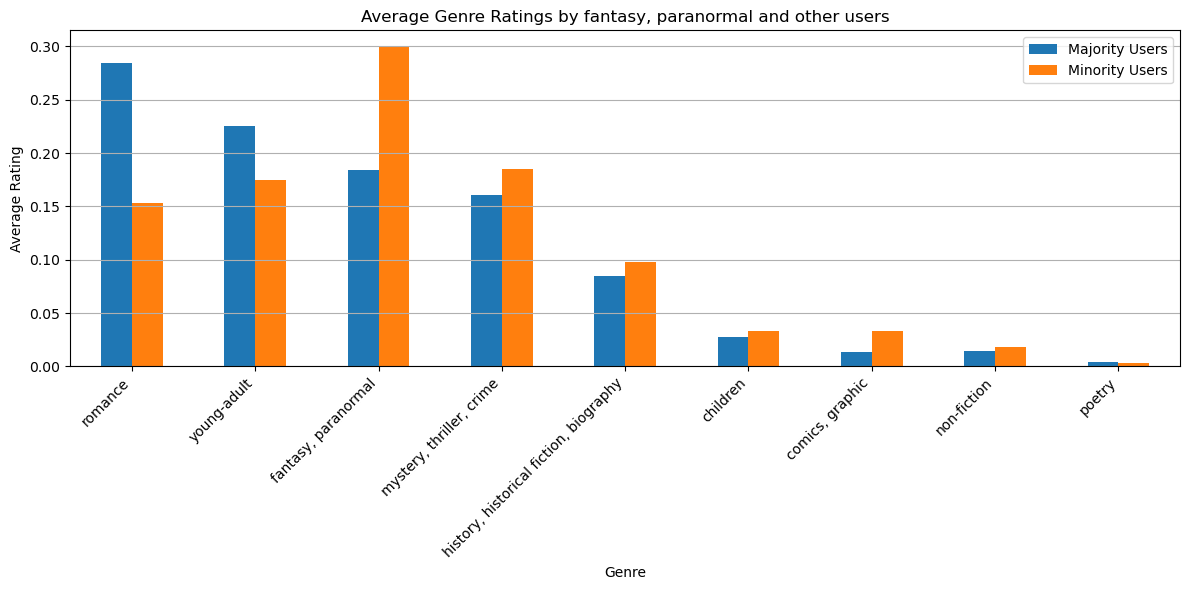

number of majority users is 17805 which constitute 0.9424624179546898% of all users
number of minority users is 1087 which constitute 0.05753758204531018% of all users


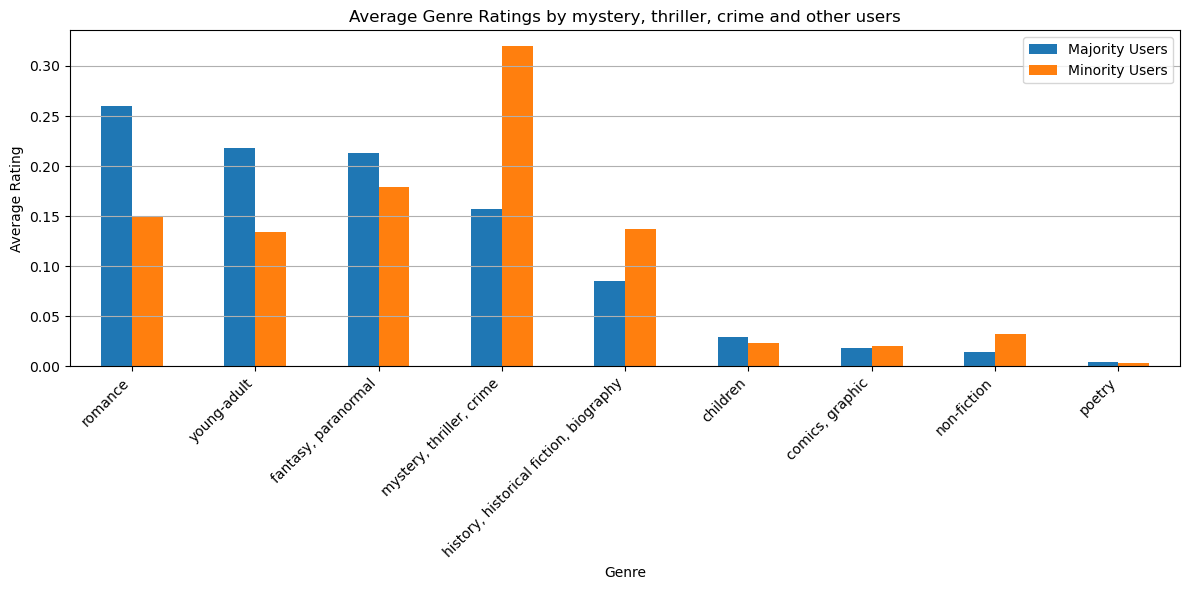

number of majority users is 18224 which constitute 0.9646411179335168% of all users
number of minority users is 668 which constitute 0.03535888206648317% of all users


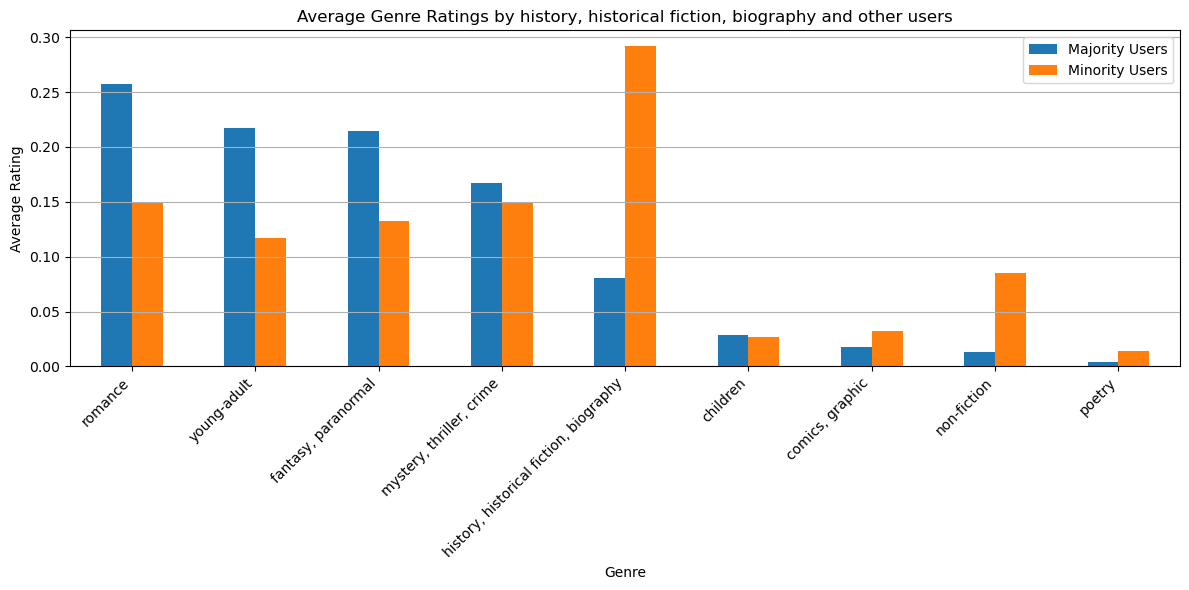

number of majority users is 18889 which constitute 0.99984120262545% of all users
number of minority users is 3 which constitute 0.0001587973745500741% of all users


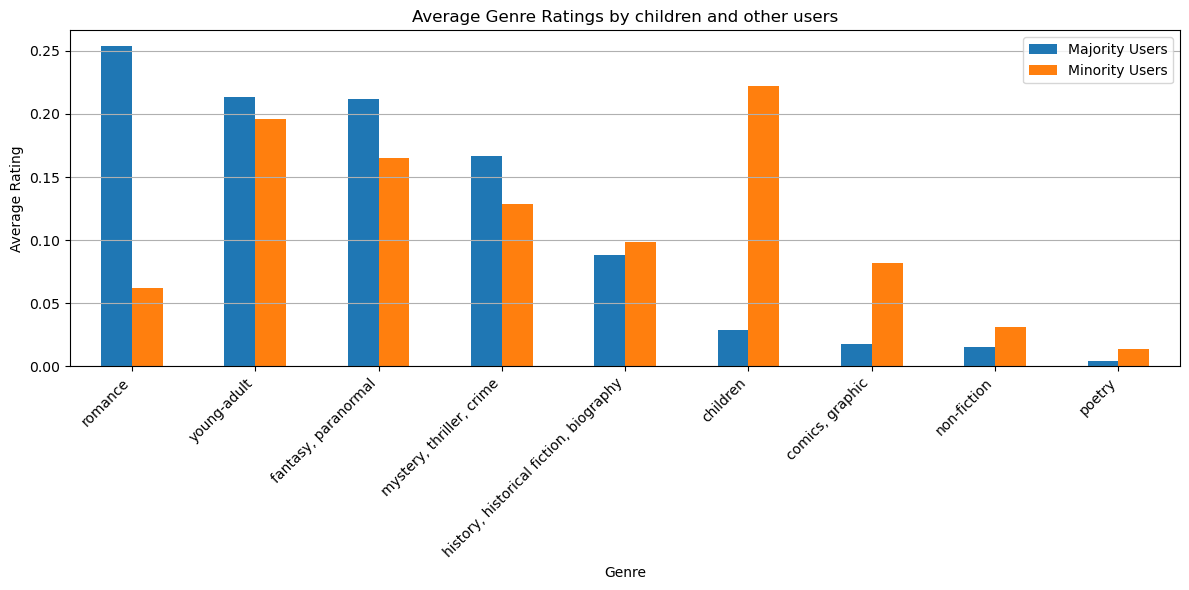

number of majority users is 18880 which constitute 0.9993648105017997% of all users
number of minority users is 12 which constitute 0.0006351894982002964% of all users


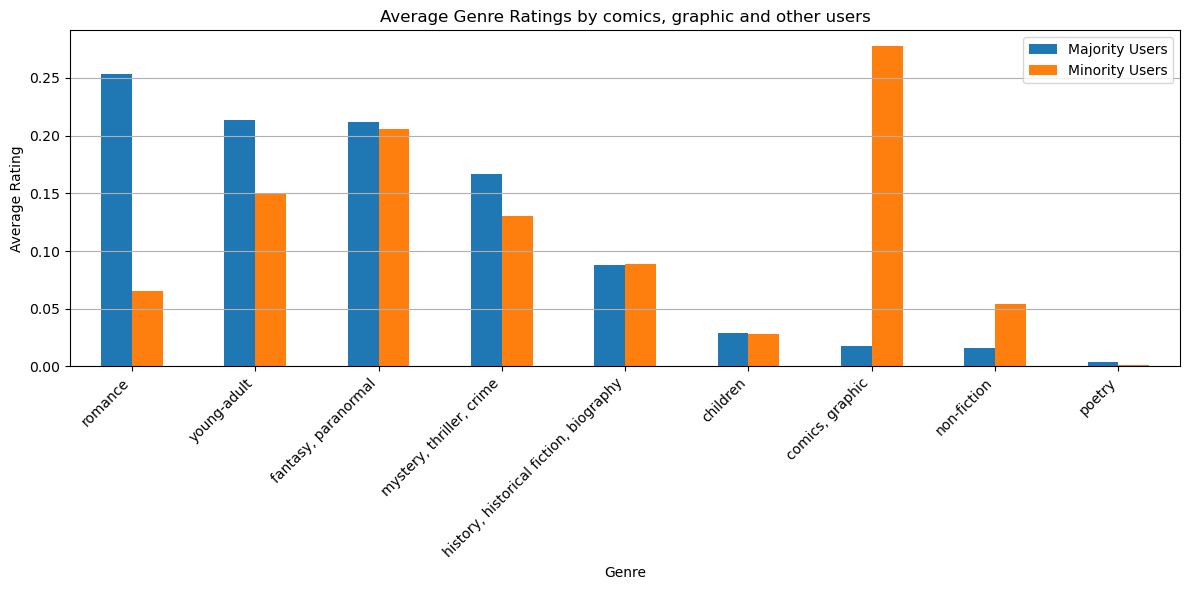

number of majority users is 18885 which constitute 0.9996294727927165% of all users
number of minority users is 7 which constitute 0.0003705272072835062% of all users


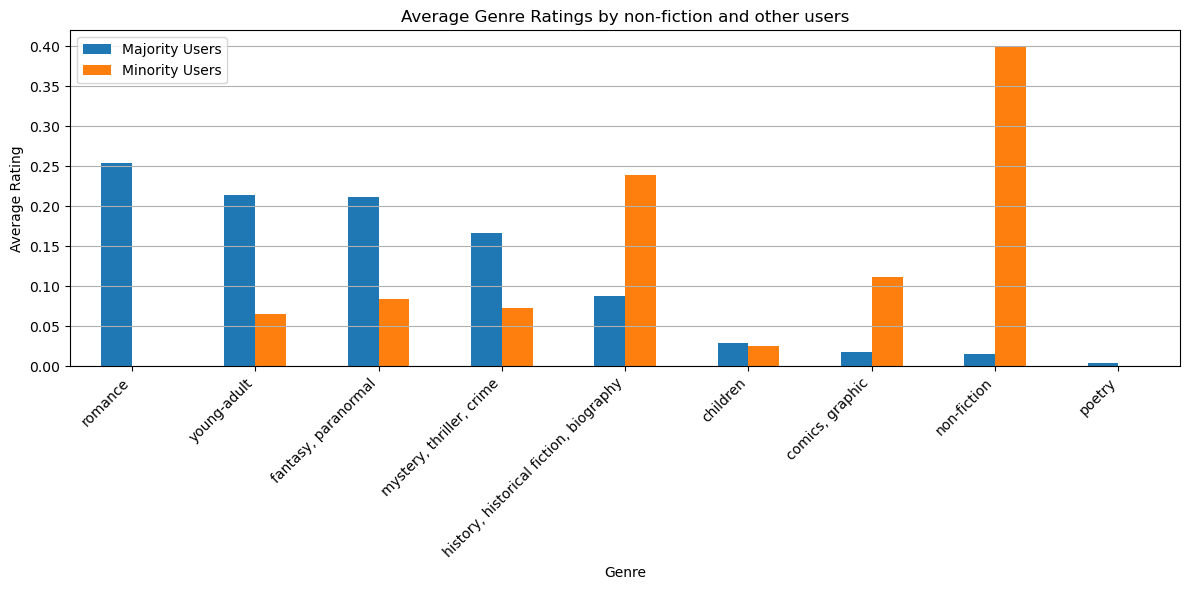

In [50]:
for i in range(1,n):
    create_plot(i)

# SVD of Ratings Matrix AND Modified Ratings Matrix

In [32]:
plt.rcParams.update({'font.size': 14})

m=18892 and n=9


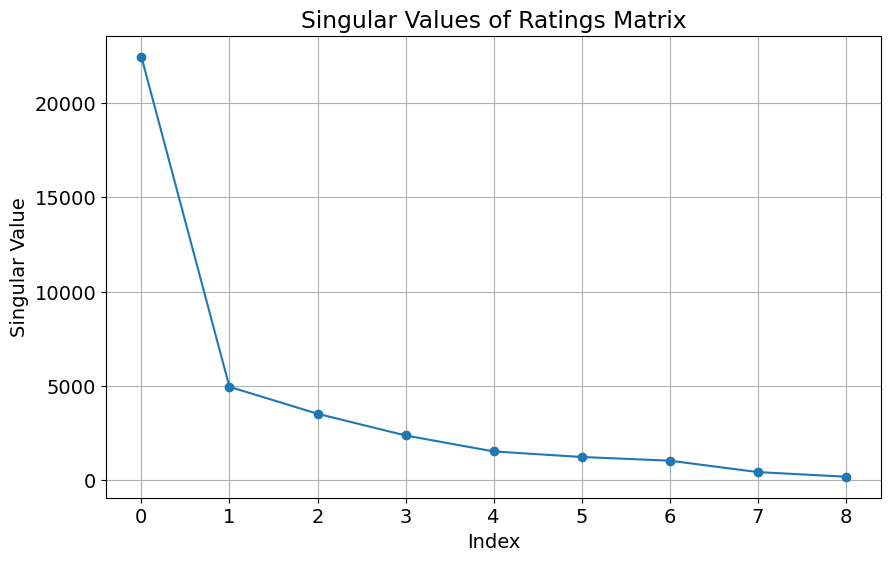

In [34]:
R = sorted_ratings_matrix
best_items = np.argmax(R, axis=1)
m,n = R.shape[0], R.shape[1]
print(f'm={m} and n={n}')
U, S, VT = np.linalg.svd(R, full_matrices=False)

plt.figure(figsize=(10, 6))
plt.plot(S, marker='o')
# plt.plot(S_tilde, marker='o')
plt.title('Singular Values of Ratings Matrix')
plt.xlabel('Index')
plt.ylabel('Singular Value')
plt.grid(True)
plt.savefig('pics/singular_values.png')
plt.show()

In [36]:
print(S[0], S[1])

22452.91294310519 4948.196755737102


In [38]:
# Functions

# Create R_Tilde
def create_R_tilde(R, items, i_star, fraction):
    
    R_tilde = np.copy(R)  # start with a copy of R
    
    for u in range(R.shape[0]):        # for each user
        for i in range(R.shape[1]):    # for each item
            if items[u] in {0}:
                    if u % fraction ==1:
                        if i == i_star:
                            R_tilde[u, i] = 2 * R.iloc[u, items[u]] / 3
            else:
                R_tilde[u, i] = R.iloc[u, i]
    
    return R_tilde
    
def alpha_loss_learner(alpha, U, S, VT):
    
    k = next((i for i, s in enumerate(S[1:], start=1) if s <= alpha), len(S))
    U_k = U[:, :k]            # (n x k)
    S_k = np.diag(S[:k])      # (k x k)
    VT_k = VT[:k, :]          # (k x m)

    # Reconstruct the matrix using the first k components
    approx_matrix = U_k @ S_k @ VT_k
    return approx_matrix, k

def get_sw_values(R, items):
    sw_values = []
    m = R.shape[0]
    for u in range(m):
        i_u = items[u]
        rating = R.iloc[u,i_u]
        sw_values.append(rating)
    return sw_values

# Welfare Change Per Favorite Genre Group
def plot(rec_items_EA, rec_items):
    SW_genre_change = np.zeros(n)
    
    for i in range(n):
        total = 0
        change = 0
        for u in range(m):
            if best_items[u] ==i:
                change += R.iloc[u,rec_items_EA[u]] - R.iloc[u,rec_items[u]]
                total += R.iloc[u,rec_items[u]]
        # print(i,change, total)
        if total !=0:
            SW_genre_change[i] = change/total*100
        else:
            SW_genre_change[i] = 0
        #SW_genre_change[i] = change/total
        
    plt.bar(genres_ordered_by_popularity, SW_genre_change)
    plt.title('SW Change by Favorite Genre')
    plt.ylabel('Total Percent Change in User Welfare')
    plt.xlabel('Genre')
    plt.xticks(rotation=45, ha='right')
    
    # Adjust layout to fit the rotated labels
    
    plt.tight_layout()
    
    plt.show()

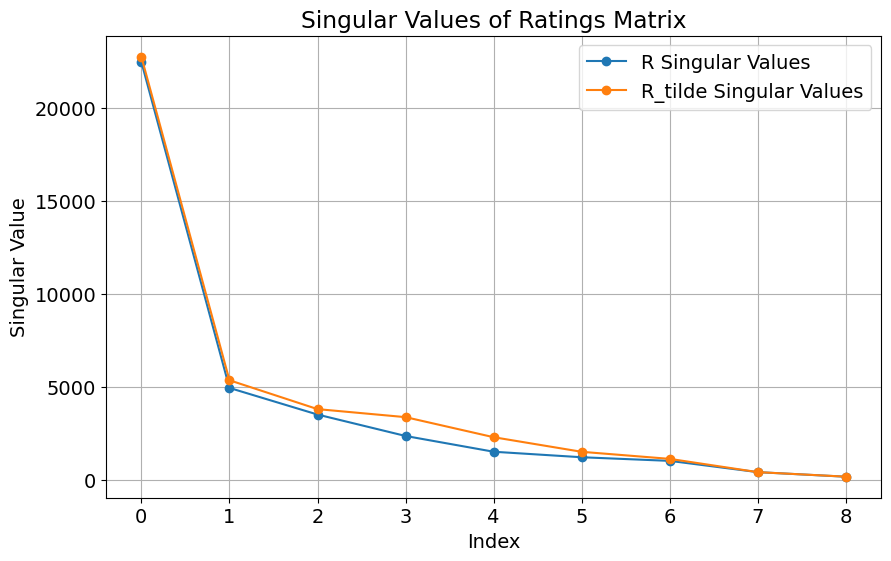

In [40]:
# Plot of Singular Values

R_tilde = create_R_tilde(R, best_items, 5, 2)
U_tilde, S_tilde, VT_tilde = np.linalg.svd(R_tilde, full_matrices=False)

plt.figure(figsize=(10, 6))
plt.plot(S, marker='o', label = 'R Singular Values')
plt.plot(S_tilde, marker='o', label = 'R_tilde Singular Values')
plt.title('Singular Values of Ratings Matrix')
plt.xlabel('Index')
plt.ylabel('Singular Value')
plt.grid(True)
plt.legend()
plt.savefig('pics/singular_value_plot.png')
plt.show()

In [42]:

def solve_EA_system(fraction, i_star):
    ## PROBLEM SET UP
    print(f"------------------------------------------")
    print(f"")
    print(f"")
    print(f"")
    
    print(f"{1/fraction} romance users uprating genre {sorted_genres[i_star]}")
    R_tilde = create_R_tilde(R, best_items, i_star, fraction)
    U_tilde, S_tilde, VT_tilde = np.linalg.svd(R_tilde, full_matrices=False)
    
    singular_value_gap = S_tilde[1]-S[1]
    
    alpha = S[1] + singular_value_gap/2
    
    
    ## WELFARE ANALYSIS
    ## MSI analysis
    R_hat, k = alpha_loss_learner(alpha, U, S, VT)
    # print(k)
    rec_items = np.argmax(R_hat, axis=1)
    
    SW_vals = get_sw_values(R, rec_items)
    
    SW_MSI = sum(SW_vals)
    
    ## EA analysis
    R_hat_tilde, k_tilde = alpha_loss_learner(alpha, U_tilde, S_tilde, VT_tilde)
    # print(k_tilde)
    rec_items_EA = np.argmax(R_hat_tilde, axis=1)
    
    SW_vals_EA = get_sw_values(R, rec_items_EA)
    
    SW_EA = sum(SW_vals_EA)
    
    print(f"The singular value gap is: {S_tilde[1]-S[1]}")
    # print(f'Social Welfare Under EA is: {SW_EA}')
    # print(f'Social Welfare Under MSI is: {SW_MSI}')
    print(f'The Ratio (rho) is: {SW_EA/SW_MSI}')
    
    
    plot(rec_items_EA, rec_items)


In [44]:
R

,romance,young-adult,"fantasy, paranormal","mystery, thriller, crime","history, historical fiction, biography",children,"comics, graphic",non-fiction,poetry
0,171.0,134.0,118.0,103.0,14.0,5.0,1.0,1.0,1.0
1,5.0,2.0,4.0,5.0,0.0,0.0,0.0,0.0,0.0
2,35.0,35.0,34.0,11.0,6.0,0.0,1.0,0.0,0.0
3,51.0,31.0,20.0,10.0,3.0,1.0,4.0,0.0,0.0
4,52.0,42.0,22.0,12.0,4.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
18887,0.0,1.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0
18888,0.0,0.0,1.0,0.0,1.0,0.0,0.0,2.0,0.0
18889,0.0,0.0,1.0,2.0,2.0,0.0,2.0,3.0,0.0
18890,1.0,2.0,11.0,5.0,50.0,2.0,9.0,63.0,0.0


In [46]:
genres = R.columns.to_list()

In [48]:
genres_short = ['Romance',
 'Young-Adult',
 'Fantasy',
 'Mystery',
 'History',
 'Children',
 'Comics and Graphic',
 'Non-fiction',
 'Poetry']

def solve_EA_system_comparison(fraction, i_star_range):
    num_plots = len(i_star_range)

    plt.figure(figsize=(6 * num_plots, 5))

    for idx, i_star in enumerate(i_star_range, start=1):
        print(f"\n------------------------------------------")
        print(f"{1/fraction} romance users uprating genre {genres[i_star]}")
        
        R_tilde = create_R_tilde(R, best_items, i_star, fraction)
        U_tilde, S_tilde, VT_tilde = np.linalg.svd(R_tilde, full_matrices=False)
        singular_value_gap = S_tilde[1] - S[1]
        alpha = S[1] + singular_value_gap / 2
        print(f"UB of {np.round(S_tilde[1])}")
        
        # MSI analysis
        R_hat, k = alpha_loss_learner(alpha, U, S, VT)
        rec_items = np.argmax(R_hat, axis=1)
        
        # EA analysis
        R_hat_tilde, k_tilde = alpha_loss_learner(alpha, U_tilde, S_tilde, VT_tilde)
        rec_items_EA = np.argmax(R_hat_tilde, axis=1)
        # welfare change
        SW_vals_MSI = get_sw_values(R, rec_items)
        SW_vals_EA = get_sw_values(R, rec_items_EA)
        SW_MSI = sum(SW_vals_MSI)
        SW_EA = sum(SW_vals_EA)
        print(f'The Ratio (rho) is: {SW_EA/SW_MSI}')
        # Bar plot logic
        SW_genre_change = np.zeros(len(genres)-1)
        for i in range(len(genres)-1):
            total = 0
            change = 0
            for u in range(m):
                if best_items[u] == i:
                    change += R.iloc[u, rec_items_EA[u]] - R.iloc[u, rec_items[u]]
                    total += R.iloc[u, rec_items[u]]
            SW_genre_change[i] = (change / total * 100) if total != 0 else 0


        colors = ['blue'] * (n-1)
        colors[i_star] = 'orange'
        genres_ = genres_short[:-1]
        plt.subplot(1, num_plots, idx)
        plt.bar(genres_, SW_genre_change, color=colors)
        plt.title(f'SW Change ({genres_short[i_star]} books uprated)')
        plt.ylabel('Change in Welfare (%)')
        plt.xlabel('Genre')
        plt.xticks(rotation=45, ha='right')
        plt.grid(True)
        plt.savefig(f'pics/plot{fraction}.png')
        # plt.subplot(1, num_plots, idx)
        # plt.bar(genres_ordered_by_popularity, SW_genre_change)
        # plt.title(f'SW Change (Genre: {sorted_genres[i_star]})')
        # plt.ylabel('Percent Change in User Welfare')
        # plt.xlabel('Genre')
        # plt.xticks(rotation=45, ha='right')
        # plt.grid(True)
    

    plt.tight_layout()
    plt.show()




In [50]:
def solve_EA_system_comparison(i_star, fractions):
    num_plots = len(fractions)
    fig, axes = plt.subplots(1, num_plots, figsize=(6 * num_plots, 5), sharex=True)

    if num_plots == 1:
        axes = [axes]  # make iterable

    for ax, fraction in zip(axes, fractions):
        print(f"\n------------------------------------------")
        print(f"{1/fraction} romance users uprating genre {genres[i_star]}")

        R_tilde = create_R_tilde(R, best_items, i_star, fraction)
        U_tilde, S_tilde, VT_tilde = np.linalg.svd(R_tilde, full_matrices=False)
        singular_value_gap = S_tilde[1] - S[1]
        alpha = S[1] + singular_value_gap / 2
        print(f"UB of {np.round(S_tilde[1])}")

        # MSI analysis
        R_hat, k = alpha_loss_learner(alpha, U, S, VT)
        rec_items = np.argmax(R_hat, axis=1)

        # EA analysis
        R_hat_tilde, k_tilde = alpha_loss_learner(alpha, U_tilde, S_tilde, VT_tilde)
        rec_items_EA = np.argmax(R_hat_tilde, axis=1)

        # Welfare change per genre
        SW_genre_change = np.zeros(len(genres) - 1)
        for i in range(len(genres) - 1):
            total = 0
            change = 0
            for u in range(m):
                if best_items[u] == i:
                    change += R.iloc[u, rec_items_EA[u]] - R.iloc[u, rec_items[u]]
                    total += R.iloc[u, rec_items[u]]
            SW_genre_change[i] = (change / total * 100) if total != 0 else 0

        colors = ['blue'] * (len(genres) - 1)
        colors[i_star] = 'orange'
        genres_ = genres_short[:-1]

        ax.bar(genres_, SW_genre_change, color=colors)
        ax.set_title(f'SW Change: 1/{fraction} Romance Users Uprating')
        ax.set_ylabel('$\Delta$ SW (%)')
        ax.grid(True)
        ax.tick_params(axis='x', rotation=45)

    #fig.text(0.5, 0.04, 'SW change: {1/fraction} Romance Users Uprating', ha='center', fontsize=12)
    plt.savefig(f'pics/SW_{genres[i_star]}.png')
    fig.tight_layout(rect=[0, 0.05, 1, 1])
    plt.show()


<>:43: SyntaxWarning: invalid escape sequence '\D'
<>:43: SyntaxWarning: invalid escape sequence '\D'
/var/folders/pr/6gwsc3p567d8z4431s4cjzqr0000gp/T/ipykernel_31762/3250682740.py:43: SyntaxWarning: invalid escape sequence '\D'
  ax.set_ylabel('$\Delta$ SW (%)')


In [52]:
def solve_EA_system_comparison(i_star, fractions):
    num_plots = len(fractions)
    fig, axes = plt.subplots(1, num_plots, figsize=(6 * num_plots, 5), sharex=True, sharey = True)
    
    x_indices = np.arange(len(genres) - 1)
    if num_plots == 1:
        axes = [axes]  # make iterable

    for ax, fraction in zip(axes, fractions):
        print(f"\n------------------------------------------")
        print(f"{1/fraction} romance users uprating genre {genres[i_star]}")

        R_tilde = create_R_tilde(R, best_items, i_star, fraction)
        U_tilde, S_tilde, VT_tilde = np.linalg.svd(R_tilde, full_matrices=False)
        singular_value_gap = S_tilde[1] - S[1]
        alpha = S[1] + singular_value_gap / 2
        print(f"UB of {np.round(S_tilde[1])}")

        # MSI analysis
        R_hat, k = alpha_loss_learner(alpha, U, S, VT)
        rec_items = np.argmax(R_hat, axis=1)

        # EA analysis
        R_hat_tilde, k_tilde = alpha_loss_learner(alpha, U_tilde, S_tilde, VT_tilde)
        rec_items_EA = np.argmax(R_hat_tilde, axis=1)

        # Welfare change per genre
        SW_genre_change = np.zeros(len(genres) - 1)
        for i in range(len(genres) - 1):
            total = 0
            change = 0
            for u in range(m):
                if best_items[u] == i:
                    change += R.iloc[u, rec_items_EA[u]] - R.iloc[u, rec_items[u]]
                    total += R.iloc[u, rec_items[u]]
            SW_genre_change[i] = (change / total * 100) if total != 0 else 0
        print(SW_genre_change)
        # Color assignment
        colors = []
        for idx in range(len(genres) - 1):
            if idx == i_star:
                colors.append('orange')
            elif idx < 5:
                colors.append('lightblue')
            else:
                colors.append('pink')
        genres_ = ['' for _ in range(len(genres) - 1)]  # Removed x-axis labels

        #genres_ = genres_short[:-1] #['' for _ in range(len(genres) - 1)]  # remove x-axis labels
        
        ax.bar(x_indices, SW_genre_change, color=colors)
        ax.set_title(f'1/{fraction} Romance Users Uprating')
        ax.set_ylabel('$\\Delta$ SW (%)')
        ax.grid(True)
        ax.set_xlabel('User Groups')

        
        # Remove x-axis tick labels but maintain spacing
        ax.set_xticks(x_indices)
        #ax.set_xticklabels([''] * len(x_indices))

    # Custom legend
    legend_elements = [
        plt.Line2D([0], [0], color='lightblue', lw=4, label='Majority Groups'),
        plt.Line2D([0], [0], color='orange', lw=4, label='Uprated Group'),
        plt.Line2D([0], [0], color='pink', lw=4, label='Minority Groups')
    ]

    axes[-1].legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))
    
    #fig.suptitle(f"Altruism with Romance Users Uprating {genres_short[i_star]} books",
                 #fontsize=16,  y=1.02)
    
    plt.savefig(f'pics/SW_{genres[i_star]}.png', bbox_inches='tight')
    fig.tight_layout(rect=[0, 0.05, 0.9, 1])  # Adjust layout for legend
    plt.show()

In [54]:
def solve_EA_system_comparison(fractions, genres_to_uprate):
    num_rows = len(fractions)
    num_cols = len(genres_to_uprate)
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(6 * num_cols, 5 * num_rows),
                             sharex=True, sharey=True)

    if num_rows == 1:
        axes = np.array([axes])
    if num_cols == 1:
        axes = axes[:, np.newaxis]

    x_indices = np.arange(len(genres) - 1)

    for row_idx, fraction in enumerate(fractions):
        for col_idx, i_star in enumerate(genres_to_uprate):
            ax = axes[row_idx, col_idx]

            print(f"\n{'-'*50}")
            print(f"1/{fraction} romance users uprating genre {genres[i_star]}")

            R_tilde = create_R_tilde(R, best_items, i_star, fraction)
            U_tilde, S_tilde, VT_tilde = np.linalg.svd(R_tilde, full_matrices=False)
            singular_value_gap = S_tilde[1] - S[1]
            alpha = S[1] + singular_value_gap / 2
            print(f"UB of {np.round(S_tilde[1])}")

            # MSI analysis
            R_hat, k = alpha_loss_learner(alpha, U, S, VT)
            rec_items = np.argmax(R_hat, axis=1)

            # EA analysis
            R_hat_tilde, k_tilde = alpha_loss_learner(alpha, U_tilde, S_tilde, VT_tilde)
            rec_items_EA = np.argmax(R_hat_tilde, axis=1)

            # Welfare change per genre
            SW_genre_change = np.zeros(len(genres) - 1)
            for i in range(len(genres) - 1):
                total, change = 0, 0
                for u in range(m):
                    if best_items[u] == i:
                        change += R.iloc[u, rec_items_EA[u]] - R.iloc[u, rec_items[u]]
                        total += R.iloc[u, rec_items[u]]
                SW_genre_change[i] = (change / total * 100) if total != 0 else 0

            # Color assignment
            colors = ['orange' if idx == i_star else 'lightblue' if idx < 5 else 'pink'
                      for idx in range(len(genres)-1)]

            ax.bar(x_indices, SW_genre_change, color=colors)
            ax.set_title(f'{genres_short[i_star]} uprated', fontsize=13)
            ax.grid(True)

            if col_idx == 0:
                ax.set_ylabel('$\\Delta$ SW (%)', fontsize=12)
            ax.set_xticks(x_indices)
            ax.set_xlabel('User Groups')
            #ax.set_xticklabels([''] * len(x_indices))

        # Row-level title
        fig.text(0.5, 0.95 - row_idx * (0.5), 
                 f'1/{fraction} Romance Users Uprating', 
                 ha='center', fontsize=16, fontweight='bold')

    # Legend
    legend_elements = [
        plt.Line2D([0], [0], color='lightblue', lw=4, label='Majority Groups'),
        plt.Line2D([0], [0], color='orange', lw=4, label='Uprated Group'),
        plt.Line2D([0], [0], color='pink', lw=4, label='Minority Groups')
    ]
    axes[0, -1].legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))

    fig.tight_layout(rect=[0, 0, 0.9, 0.92])
    plt.savefig('pics/romance_users_uprating.png', bbox_inches='tight')
    plt.show()


In [56]:
fractions = [2,3]

solve_EA_system_comparison(5, fractions)
solve_EA_system_comparison(6, fractions)
solve_EA_system_comparison(7, fractions)

TypeError: object of type 'int' has no len()

In [58]:
def solve_EA_system_comparison(fractions, genres_to_uprate):
    num_rows = len(fractions)
    num_cols = len(genres_to_uprate)
    fig, axes = plt.subplots(num_rows, num_cols,
                             figsize=(6 * num_cols, 5 * num_rows),
                             sharex=True, sharey=True)

    if num_rows == 1:
        axes = np.array([axes])
    if num_cols == 1:
        axes = axes[:, np.newaxis]

    x_indices = np.arange(1,len(genres))

    for row_idx, fraction in enumerate(fractions):
        for col_idx, i_star in enumerate(genres_to_uprate):
            ax = axes[row_idx, col_idx]

            # Compute and plot welfare changes (your existing code)
            R_tilde = create_R_tilde(R, best_items, i_star, fraction)
            U_tilde, S_tilde, VT_tilde = np.linalg.svd(R_tilde, full_matrices=False)
            singular_value_gap = S_tilde[1] - S[1]
            alpha = S[1] + singular_value_gap / 2

            R_hat, k = alpha_loss_learner(alpha, U, S, VT)
            rec_items = np.argmax(R_hat, axis=1)

            R_hat_tilde, k_tilde = alpha_loss_learner(alpha, U_tilde, S_tilde, VT_tilde)
            rec_items_EA = np.argmax(R_hat_tilde, axis=1)

            SW_genre_change = np.zeros(len(genres) - 1)
            for i in range(len(genres) - 1):
                total, change = 0, 0
                for u in range(m):
                    if best_items[u] == i:
                        change += R.iloc[u, rec_items_EA[u]] - R.iloc[u, rec_items[u]]
                        total += R.iloc[u, rec_items[u]]
                SW_genre_change[i] = (change / total * 100) if total != 0 else 0
            

            colors = ['lightblue' if idx < 5 else 'pink'
                      for idx in range(len(genres)-1)]

            ax.bar(x_indices, SW_genre_change, color=colors)

            # Remove titles from bottom row plots
            if row_idx == 0:
                ax.set_title(f'{genres_short[i_star]} books uprated', pad=12)

            ax.grid(True)

            # Only set y-label for first column plots
            if col_idx == 0:
                ax.set_ylabel('$\\Delta$ SW (%)', fontsize=12, labelpad=8)

            # Only add x-axis label on bottom row plots
            if row_idx == num_rows - 1:
                ax.set_xlabel('User Groups', labelpad=10)
                ax.set_xticks(x_indices)
                #ax.set_xticklabels([''] * len(x_indices))
            else:
                ax.set_xticks(x_indices)
                ax.set_xticklabels([''] * len(x_indices))
                ax.set_xlabel('')  # remove x-axis label from top row plots

        # Row-level suptitles clearly placed
        #fig.text(0.5, 0.97 - row_idx*(0.47),
                 #f'1/{fraction} Romance Users Uprating',
                 #ha='center')

    # Custom legend placed outside plots
    legend_elements = [
        plt.Line2D([0], [0], color='lightblue', lw=4, label='Majority Groups'),
       # plt.Line2D([0], [0], color='orange', lw=4, label='Uprated Group'),
        plt.Line2D([0], [0], color='pink', lw=4, label='Minority Groups')
    ]
    axes[0, -1].legend(handles=legend_elements,
                       loc='center left', bbox_to_anchor=(1.02, 0.5))

    # Adjust subplot spacing carefully
    plt.subplots_adjust(hspace=0.3, wspace=0.15)

    fig.tight_layout(rect=[0, 0, 0.88, 0.93])

    plt.savefig(f'pics/romance_users_uprating_{fraction}.png', bbox_inches='tight')
    plt.show()


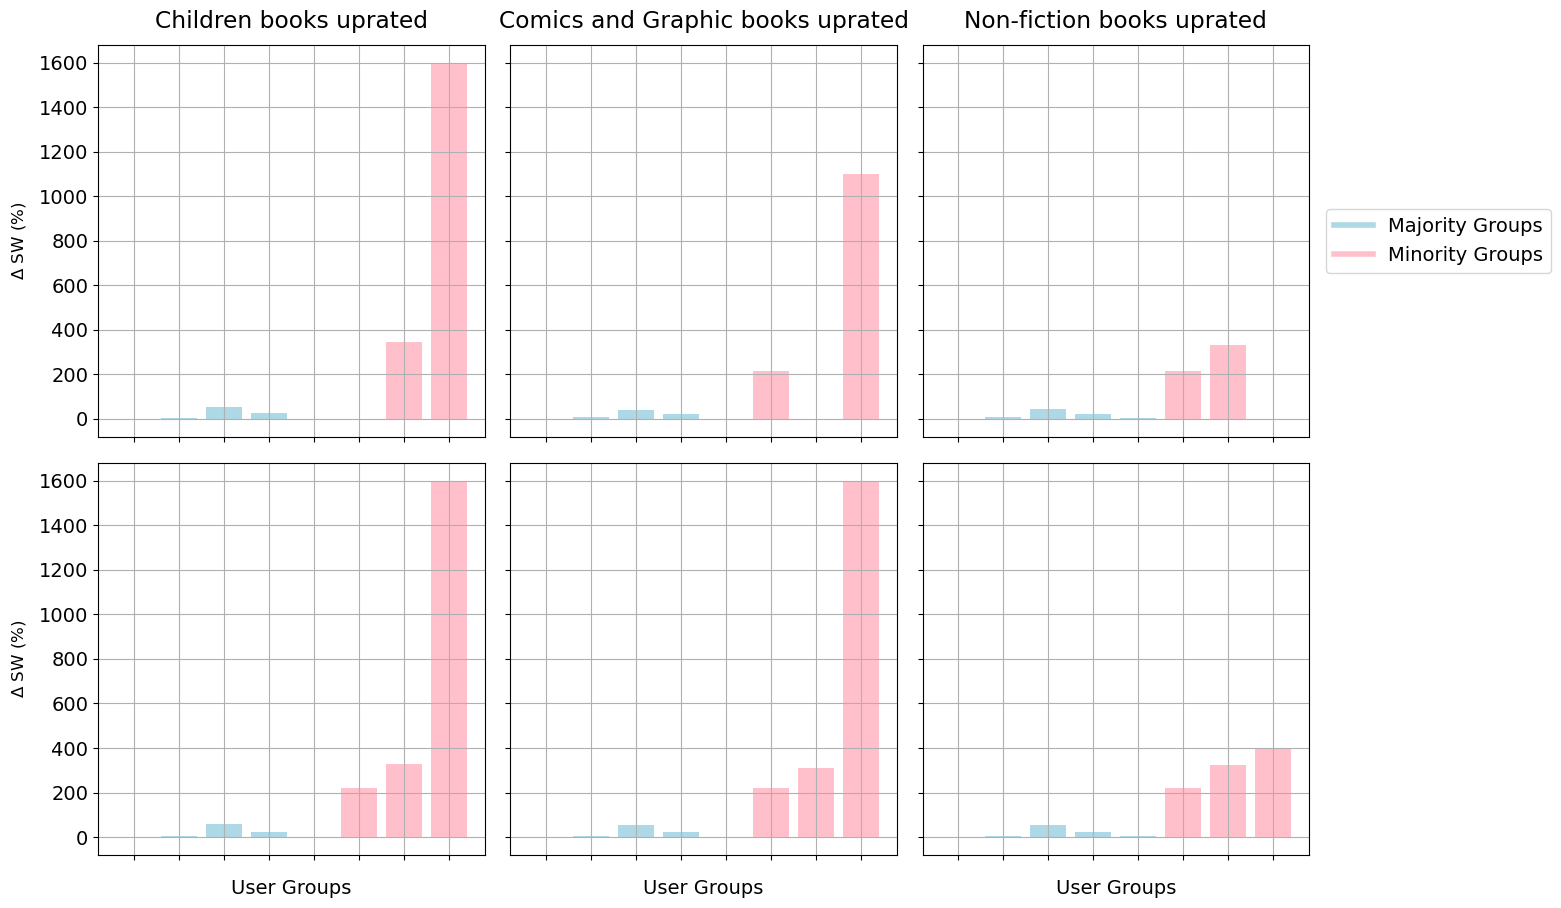

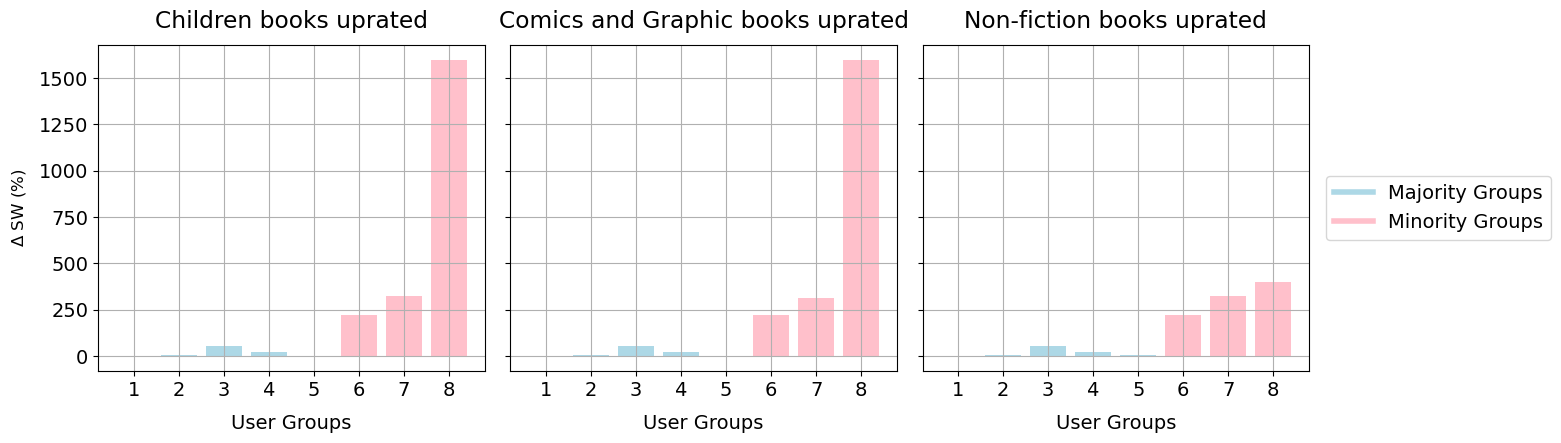

In [60]:
fractions = [2,3]
genres_to_uprate = [5,6,7]
solve_EA_system_comparison(fractions, genres_to_uprate)
solve_EA_system_comparison([3], genres_to_uprate)


In [61]:
def solve_EA_system_comparison_recs(fraction, genres_to_uprate):
    
    num_rows = len(genres_to_uprate)
    num_cols = len(genres)-1
    fraction_top_item = np.zeros((num_rows, num_cols))

    for n in range(len(genres_to_uprate)):
        i_star = genres_to_uprate[n]
        
        # Compute and plot welfare changes (your existing code)
        R_tilde = create_R_tilde(R, best_items, i_star, fraction)
        U_tilde, S_tilde, VT_tilde = np.linalg.svd(R_tilde, full_matrices=False)
        singular_value_gap = S_tilde[1] - S[1]
        alpha = S[1] + singular_value_gap / 2

        # R_hat, k = alpha_loss_learner(alpha, U, S, VT)
        # rec_items = np.argmax(R_hat, axis=1)

        R_hat_tilde, k_tilde = alpha_loss_learner(alpha, U_tilde, S_tilde, VT_tilde)
        rec_items_EA = np.argmax(R_hat_tilde, axis=1)

        for i in range(len(genres) - 1):
            total, change = 0, 0
            for u in range(m):
                if best_items[u] == i:
                    total += 1
                    if rec_items_EA[u] == best_items[u]:
                        change += 1
            fraction_top_item[n,i] = np.round((change / total * 100))
    return fraction_top_item
    


[56.09252594  9.44844379 34.45903028  0.          0.          0.
  0.          0.          0.        ]
[53.65233961 24.97882702 21.36883337  0.          0.          0.
  0.          0.          0.        ]
[56.1454584  21.03006564 22.82447597  0.          0.          0.
  0.          0.          0.        ]
[57.25704002  1.99555367 40.74740631  0.          0.          0.
  0.          0.          0.        ]
[55.15562143  8.84501376 35.99936481  0.          0.          0.
  0.          0.          0.        ]
[57.42113064  9.14143553 33.43743383  0.          0.          0.
  0.          0.          0.        ]


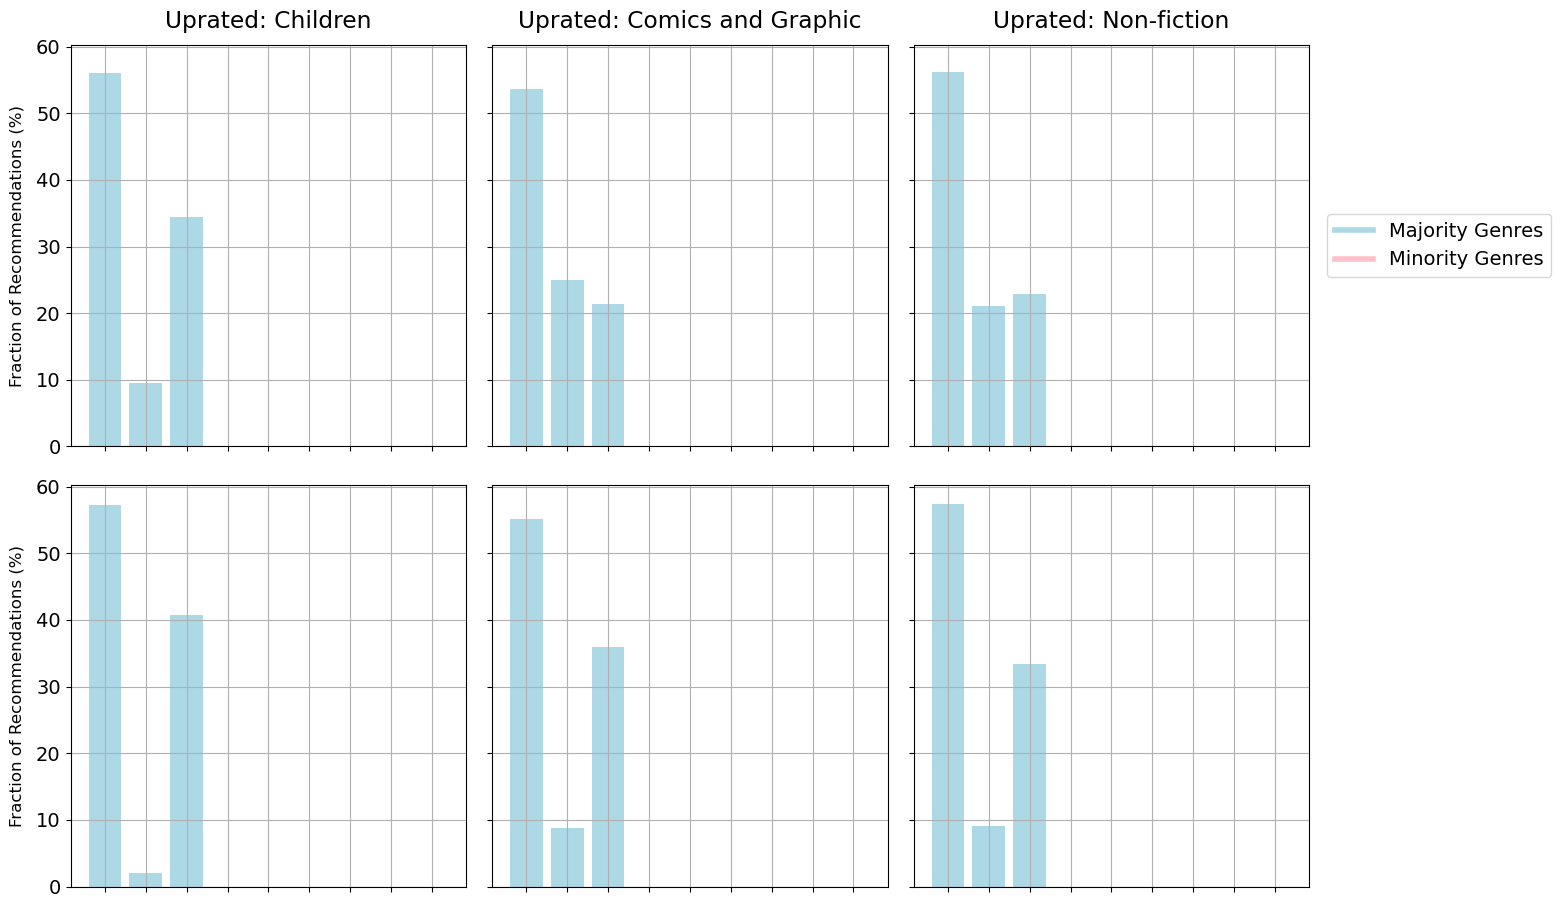

In [68]:
plot_recommended_genre_distribution(fractions, genres_to_uprate)

In [64]:
def plot_recommended_genre_distribution(fractions, genres_to_uprate):
    num_rows = len(fractions)
    num_cols = len(genres_to_uprate)
    fig, axes = plt.subplots(num_rows, num_cols,
                             figsize=(6 * num_cols, 5 * num_rows),
                             sharex=True, sharey=True)

    if num_rows == 1:
        axes = np.array([axes])
    if num_cols == 1:
        axes = axes[:, np.newaxis]

    x_indices = np.arange(len(genres))

    for row_idx, fraction in enumerate(fractions):
        for col_idx, i_star in enumerate(genres_to_uprate):
            ax = axes[row_idx, col_idx]

            # Create perturbed R_tilde
            R_tilde = create_R_tilde(R, best_items, i_star, fraction)
            U_tilde, S_tilde, VT_tilde = np.linalg.svd(R_tilde, full_matrices=False)

            singular_value_gap = S_tilde[1] - S[1]
            alpha = S[1] + singular_value_gap / 2

            R_hat_tilde, _ = alpha_loss_learner(alpha, U_tilde, S_tilde, VT_tilde)
            rec_items_EA = np.argmax(R_hat_tilde, axis=1)

            # Now compute: fraction of users recommended each genre
            genre_rec_counts = np.zeros(len(genres))  # counts for each genre
            total_users = len(best_items)  # total number of users

            for u in range(m):
                    recommended_genre = rec_items_EA[u]
                    if recommended_genre < len(genres):
                        genre_rec_counts[recommended_genre] += 1

            genre_rec_fractions = genre_rec_counts / total_users * 100  # percentage
            print(genre_rec_fractions)

            colors = ['lightblue' if idx < 5 else 'pink' for idx in range(len(genres))]

            ax.bar(x_indices, genre_rec_fractions, color=colors)

            # Titles and labels
            if row_idx == 0:
                ax.set_title(f'Uprated: {genres_short[i_star]}', pad=12)
            if col_idx == 0:
                ax.set_ylabel('Fraction of Recommendations (%)', fontsize=12, labelpad=8)
            if row_idx == num_rows:
                ax.set_xlabel('Recommended Genres', labelpad=10)
                ax.set_xticks(genres)
                ax.set_xticklabels(genres_short[:-1], rotation=45, ha='right')
            else:
                ax.set_xticks(x_indices)
                ax.set_xticklabels([''] * len(x_indices))
                ax.set_xlabel('')

            ax.grid(True)
        
    # Custom legend
    legend_elements = [
        plt.Line2D([0], [0], color='lightblue', lw=4, label='Majority Genres'),
        plt.Line2D([0], [0], color='pink', lw=4, label='Minority Genres')
    ]
    axes[0, -1].legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1.02, 0.5))

    plt.subplots_adjust(hspace=0.3, wspace=0.15)
    fig.tight_layout(rect=[0, 0, 0.88, 0.93])

    plt.show()


[56.09252594  9.44844379 34.45903028  0.          0.          0.
  0.          0.          0.        ]
[53.65233961 24.97882702 21.36883337  0.          0.          0.
  0.          0.          0.        ]
[56.1454584  21.03006564 22.82447597  0.          0.          0.
  0.          0.          0.        ]
[57.25704002  1.99555367 40.74740631  0.          0.          0.
  0.          0.          0.        ]
[55.15562143  8.84501376 35.99936481  0.          0.          0.
  0.          0.          0.        ]
[57.42113064  9.14143553 33.43743383  0.          0.          0.
  0.          0.          0.        ]


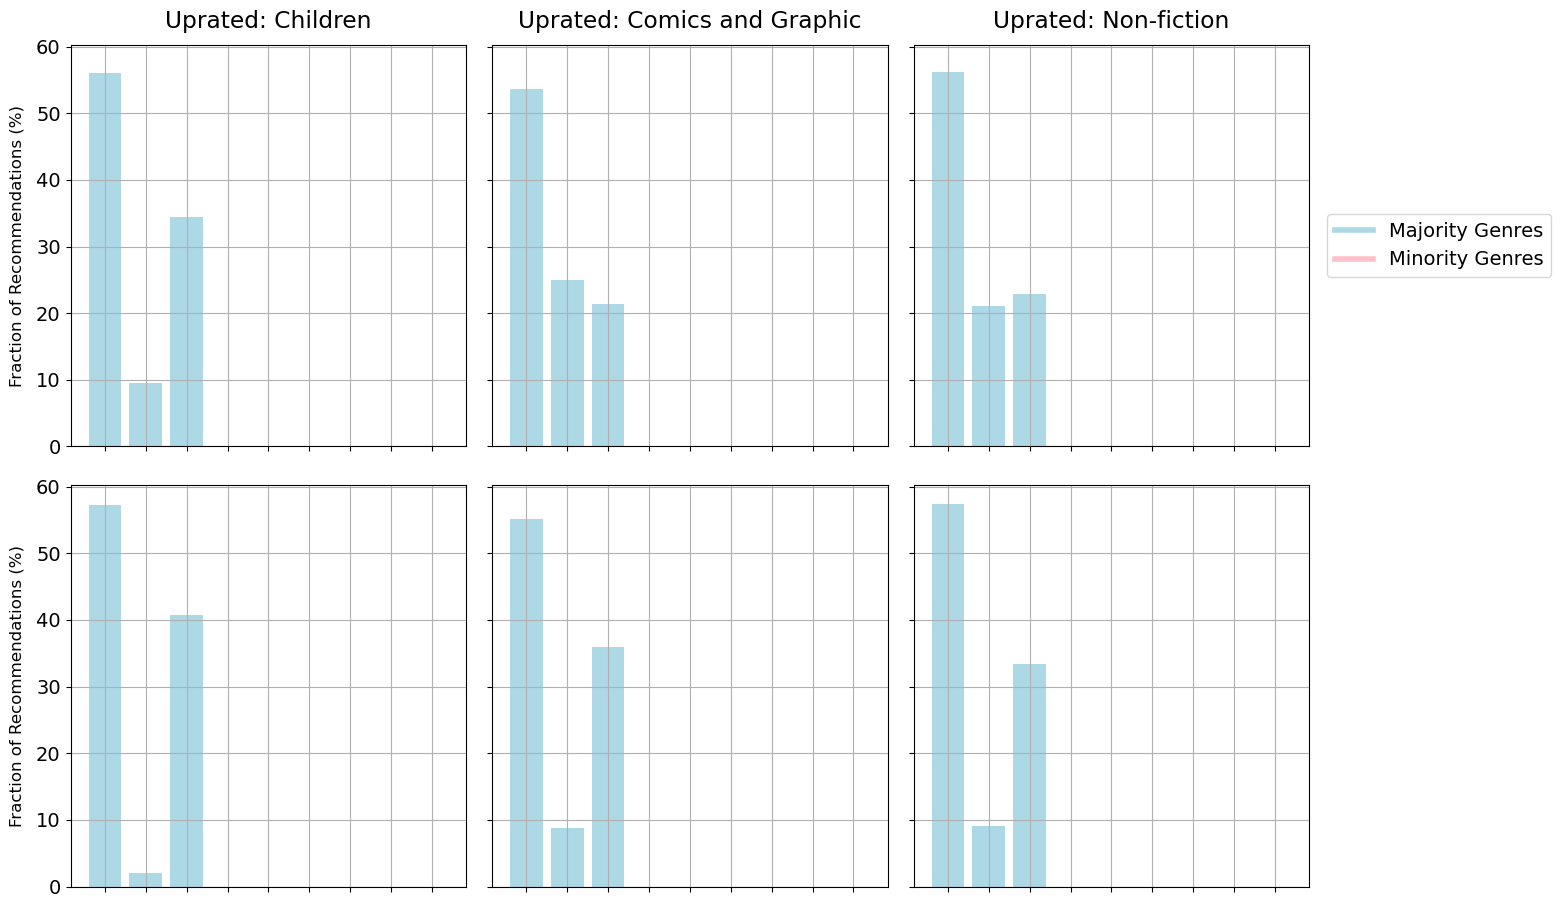

In [66]:
plot_recommended_genre_distribution(fractions, genres_to_uprate)

In [126]:
alpha = S[1]
R_hat, k = alpha_loss_learner(alpha, U, S, VT)
rec_items = np.argmax(R_hat, axis=1)
num_rows = len(genres)-1
fraction_top_item = np.zeros(num_rows)
for i in range(len(genres) - 1):
            total, change = 0, 0
            for u in range(m):
                if best_items[u] == i:
                    total += 1
                    if rec_items[u] == best_items[u]:
                        change += 1
            fraction_top_item[i] = np.round((change / total * 100))

In [93]:
create_R_tilde(R, best_items, genres_to_uprate[1], 2)

array([[171.        , 134.        , 118.        , ...,   1.        ,
          1.        ,   1.        ],
       [  5.        ,   2.        ,   4.        , ...,   3.33333333,
          0.        ,   0.        ],
       [ 35.        ,  35.        ,  34.        , ...,   1.        ,
          0.        ,   0.        ],
       ...,
       [  0.        ,   0.        ,   1.        , ...,   2.        ,
          3.        ,   0.        ],
       [  1.        ,   2.        ,  11.        , ...,   9.        ,
         63.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   2.        ,
          5.        ,   0.        ]])

In [122]:
fractions = [2,3]
genres_to_uprate = [5,6,7]
A2 = solve_EA_system_comparison_recs(2, genres_to_uprate)
A3 = solve_EA_system_comparison_recs(3, genres_to_uprate)
print(
print(A2)
print(A3)

[[95. 20. 87.  0.  0.  0.  0.  0.]
 [95. 45. 57.  0.  0.  0.  0.  0.]
 [97. 41. 66.  0.  0.  0.  0.  0.]]
[[97.  4. 93.  0.  0.  0.  0.  0.]
 [97. 18. 85.  0.  0.  0.  0.  0.]
 [98. 19. 84.  0.  0.  0.  0.  0.]]


In [128]:
print(fraction_top_item)

[100.   0.   0.   0.   0.   0.   0.   0.]
